In [1]:
import tensorflow as tf

from tensorflow.keras.layers import Dense, Flatten, Conv2D, Dropout
from tensorflow.keras.models import Sequential
from tensorflow.keras import Model
from tensorflow import keras

import seaborn as sns
import matplotlib as mp
%matplotlib inline
import math
import numpy as np
from datetime import datetime
import io
import itertools
from packaging import version
from six.moves import range


import matplotlib.pyplot as plt
import sklearn.metrics

print("TensorFlow version: ", tf.__version__)
assert version.parse(tf.__version__).release[0] >= 2, \
    "This notebook requires TensorFlow 2.0 or above."


"""this is important because i realized the model might not reset"""
tf.keras.backend.clear_session()

plt.style.use('seaborn')
plt.rcParams['figure.figsize'] = (14.0, 5.0)

TensorFlow version:  2.1.0


# Table of contents
1. [Baseline Model](#model1)
2. [Adding Layers](#model2)
3. [Adding Convolutions](#model3)
3. [Model Comparison](#compare)

Random seed for reproduction of results

In [2]:
np.random.seed(7)

Load and prep of dataset

In [3]:
mnist = tf.keras.datasets.mnist
(x_train, y_train), (x_test, y_test) = mnist.load_data()
x_train, x_test = x_train / 255.0, x_test / 255.0

x2_train = x_train[..., tf.newaxis]
x2_test = x_test[..., tf.newaxis]

Batch and shuffle

In [4]:
train_ds = tf.data.Dataset.from_tensor_slices((x2_train, y_train)).shuffle(10000).batch(32)
test_ds = tf.data.Dataset.from_tensor_slices((x2_test, y_test)).batch(32)

class_names = ['0', '1', '2', '3', '4', 
    '5', '6', '7', '8', '9']

In [5]:
img = np.reshape(x_train[0], (-1, 28, 28, 1))

add training example to TensorBoard

In [6]:
!rm -rf logs

# Creates a file writer for the log directory. I made it so that different categories contain different stuf
logdir = "logs/sample_data/"
file_writer = tf.summary.create_file_writer(logdir)

with file_writer.as_default():
    images = np.reshape(x_train[0:25], (-1, 28, 28, 1))
    tf.summary.image("25 training data examples", images, max_outputs=25, step=0)

Visualization of input images inline + TensorBoard

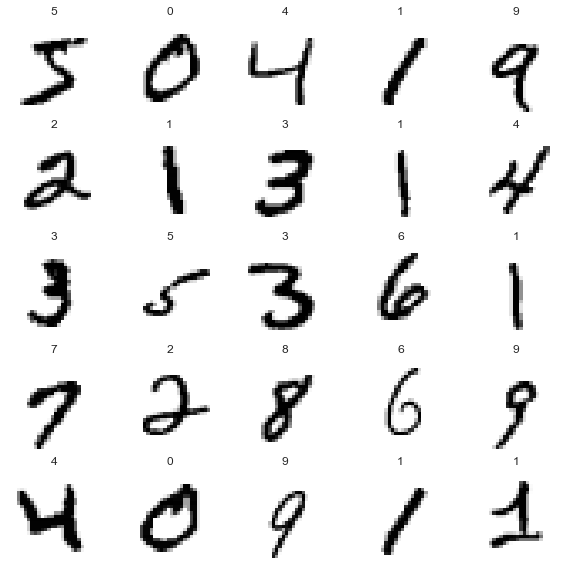

<Figure size 1008x360 with 0 Axes>

In [7]:
def plot_to_image(figure):
    buf = io.BytesIO()
    plt.savefig(buf, format='png')
    plt.close(figure)
    buf.seek(0)
    # Convert PNG buffer to TF image
    image = tf.image.decode_png(buf.getvalue(), channels=4)
    # Add the batch dimension
    image = tf.expand_dims(image, 0)
    return image

def image_grid():
    figure = plt.figure(figsize=(10,10))
    for i in range(25):
    # Start next subplot.
        plt.subplot(5, 5, i + 1, title=class_names[y_train[i]])
        plt.xticks([])
        plt.yticks([])
        plt.grid(False)
        plt.imshow(x_train[i], cmap=plt.cm.binary)
    plt.show()
    return figure

figure = image_grid()
with file_writer.as_default():
    tf.summary.image("Training data", plot_to_image(figure), step=0)

# Baseline Model <a name="introduction"></a>
* Flattening Layer
* Dense Layer 1   w/ RELU activation
* Dropout Layer 1 w/ 30% dropout rate
* Dense Layer 2   w/ RELU activation

Using model subclassing to build model

In [8]:
class ModelBaseline(Model):
    def __init__(self):
        super(ModelBaseline, self).__init__()
        self.flat = Flatten()
        self.d1 = Dense(45, activation='relu')
        self.drop = Dropout(0.3)
        self.d2 = Dense(35, activation='relu')
    def call(self, x):
        x = self.flat(x)
        x = self.d1(x)
        x = self.drop(x)
        return self.d2(x)

model=ModelBaseline()

Loss function and Optimizer selection

In [9]:
# It uses crossentropy between the labels and predictions to compute loss.
loss_object = tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True)
optimizer = tf.keras.optimizers.Adam()

Error metric selection

In [10]:
train_loss = tf.keras.metrics.Mean(name='train_loss')
train_acc = tf.keras.metrics.SparseCategoricalAccuracy(name='train_accuracy')

test_loss = tf.keras.metrics.Mean(name='test_loss')
test_acc = tf.keras.metrics.SparseCategoricalAccuracy(name='test_accuracy')

Model training using gradient tape

In [11]:
@tf.function
def train_step(images, labels):
    with tf.GradientTape() as tape:
        predictions = model(images, training=True)
        loss = loss_object(labels, predictions)
    gradients = tape.gradient(loss, model.trainable_variables)
    optimizer.apply_gradients(zip(gradients, model.trainable_variables))

    train_loss(loss)
    train_acc(labels, predictions)

Test function

In [12]:
@tf.function
def test_step(images, labels):
    predictions = model(images, training=False)
    t_loss = loss_object(labels, predictions)

    test_loss(t_loss)
    test_acc(labels, predictions)

Add test and train plots to TensorBoard

In [13]:
!rm -rf logs/gradient_tape

train_log_dir = 'logs/gradient_tape/basline_model/train'
test_log_dir = 'logs/gradient_tape/baseline_model/test'
train_summary_writer = tf.summary.create_file_writer(train_log_dir)
test_summary_writer = tf.summary.create_file_writer(test_log_dir)

In [14]:
EPOCHS = 10

In [15]:
train_loss_results_baseline = []
train_accuracy_results_baseline = []
test_loss_results_baseline = []
test_accuracy_results_baseline = []

for epoch in range(EPOCHS):
  # Reset the metrics at the start of the next epoch
    train_loss.reset_states()
    train_acc.reset_states()
    test_loss.reset_states()
    train_acc.reset_states()

    for images, labels in train_ds:
        train_step(images, labels)
    with train_summary_writer.as_default():
        tf.summary.scalar('loss', train_loss.result(), step=epoch)
        tf.summary.scalar('accuracy', train_acc.result(), step=epoch)

    for test_images, test_labels in test_ds:
        test_step(test_images, test_labels)
    with test_summary_writer.as_default():
        tf.summary.scalar('loss', test_loss.result(), step=epoch)
        tf.summary.scalar('accuracy', test_acc.result(), step=epoch)

    template = 'Epoch {}, Loss: {}, Accuracy: {}, Test Loss: {}, Test Accuracy: {}'
    print(template.format(epoch + 1,
                        train_loss.result(),
                        train_acc.result() * 100,
                        test_loss.result(),
                        test_acc.result() * 100))
    train_loss_results_baseline.append(train_loss.result())
    train_accuracy_results_baseline.append(train_acc.result() * 100)
    test_loss_results_baseline.append(test_loss.result())
    test_accuracy_results_baseline.append(test_acc.result() * 100)


If you intended to run this layer in float32, you can safely ignore this warning. If in doubt, this warning is likely only an issue if you are porting a TensorFlow 1.X model to TensorFlow 2.

To change all layers to have dtype float64 by default, call `tf.keras.backend.set_floatx('float64')`. To change just this layer, pass dtype='float64' to the layer constructor. If you are the author of this layer, you can disable autocasting by passing autocast=False to the base Layer constructor.

Epoch 1, Loss: 0.5577943921089172, Accuracy: 84.4866714477539, Test Loss: 0.22652089595794678, Test Accuracy: 93.37000274658203
Epoch 2, Loss: 0.2907174229621887, Accuracy: 91.55667114257812, Test Loss: 0.17418643832206726, Test Accuracy: 94.09500122070312
Epoch 3, Loss: 0.2503025531768799, Accuracy: 92.59832763671875, Test Loss: 0.1487274169921875, Test Accuracy: 94.58333587646484
Epoch 4, Loss: 0.22405830025672913, Accuracy: 93.44833374023438, Test Loss: 0.14515461027622223, Test Accuracy: 94.88000488

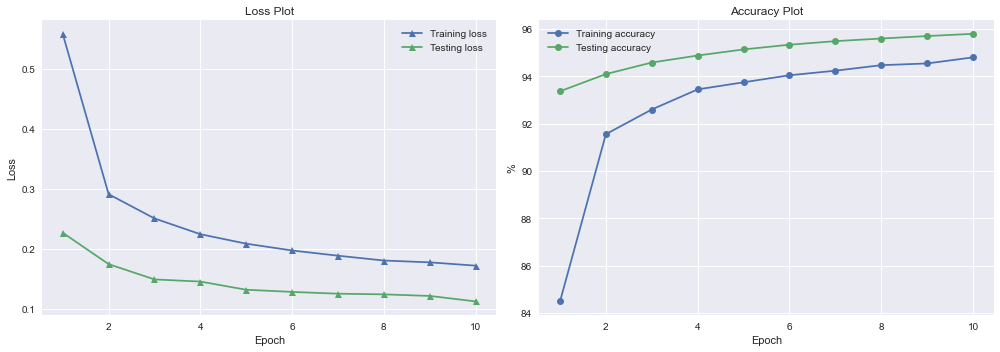

In [16]:
fig, (ax1, ax2) = plt.subplots(1,2)
ax1.plot([x for x in range(1,EPOCHS+1)], train_loss_results_baseline, label='Training loss', marker='^')
ax1.plot([x for x in range(1,EPOCHS+1)], test_loss_results_baseline, label='Testing loss', marker='^')
ax1.set_title("Loss Plot")
ax1.set_xlabel("Epoch")
ax1.set_ylabel("Loss")
ax2.plot([x for x in range(1,EPOCHS+1)], train_accuracy_results_baseline, label='Training accuracy', marker='o')
ax2.plot([x for x in range(1,EPOCHS+1)], test_accuracy_results_baseline, label='Testing accuracy', marker='o')
ax2.set_title("Accuracy Plot")
ax2.set_xlabel("Epoch")
ax2.set_ylabel("%")
ax1.legend()
ax2.legend()
fig.tight_layout()

In [17]:
model.summary()

Model: "model_baseline"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
flatten (Flatten)            multiple                  0         
_________________________________________________________________
dense (Dense)                multiple                  35325     
_________________________________________________________________
dropout (Dropout)            multiple                  0         
_________________________________________________________________
dense_1 (Dense)              multiple                  1610      
Total params: 36,935
Trainable params: 36,935
Non-trainable params: 0
_________________________________________________________________


# Adding Layers <a name="model2"></a>
* Flattening Layer
* Dense Layer 1   w/ RELU activation
* Dropout Layer 1 w/ 30% dropout rate
* Dense Layer 2   w/ RELU activation
* Dense Layer 3   w/ RELU activation
* Dense Layer 4   w/ Softmax activation

In [18]:
class ModelDenser(Model):
    def __init__(self):
        super(ModelDenser, self).__init__()
        self.flat = Flatten()
        self.d1 = Dense(45, activation='relu')
        self.drop = Dropout(0.3)
        self.d2 = Dense(35, activation='relu')
        self.d3 = Dense(23, activation='relu')
        self.d4 = Dense(10, activation='softmax')
    def call(self, x):
        x = self.flat(x)
        x = self.d1(x)
        x = self.drop(x)
        x = self.d2(x)
        x = self.d3(x)
        return self.d4(x)

model=ModelDenser()

In [19]:
loss_object = tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True)
optimizer = tf.keras.optimizers.Adam()

In [20]:
train_loss = tf.keras.metrics.Mean(name='train_loss')
train_acc = tf.keras.metrics.SparseCategoricalAccuracy(name='train_accuracy')

test_loss = tf.keras.metrics.Mean(name='test_loss')
test_acc = tf.keras.metrics.SparseCategoricalAccuracy(name='test_accuracy')

In [21]:
@tf.function
def train_step(images, labels):
    with tf.GradientTape() as tape:
        predictions = model(images, training=True)
        loss = loss_object(labels, predictions)
    gradients = tape.gradient(loss, model.trainable_variables)
    optimizer.apply_gradients(zip(gradients, model.trainable_variables))

    train_loss(loss)
    train_acc(labels, predictions)

In [22]:
@tf.function
def test_step(images, labels):
    predictions = model(images, training=False)
    t_loss = loss_object(labels, predictions)

    test_loss(t_loss)
    test_acc(labels, predictions)

In [23]:
train_log_dir = 'logs/gradient_tape/basline_dense/train'
test_log_dir = 'logs/gradient_tape/baseline_dense/test'
train_summary_writer = tf.summary.create_file_writer(train_log_dir)
test_summary_writer = tf.summary.create_file_writer(test_log_dir)

In [24]:
EPOCHS = 10

In [25]:
train_loss_results_denser = []
train_accuracy_results_denser = []
test_loss_results_denser = []
test_accuracy_results_denser = []

for epoch in range(EPOCHS):
  # Reset the metrics at the start of the next epoch
    train_loss.reset_states()
    train_acc.reset_states()
    test_loss.reset_states()
    train_acc.reset_states()

    for images, labels in train_ds:
        train_step(images, labels)
    with train_summary_writer.as_default():
        tf.summary.scalar('loss', train_loss.result(), step=epoch)
        tf.summary.scalar('accuracy', train_acc.result(), step=epoch)

    for test_images, test_labels in test_ds:
        test_step(test_images, test_labels)
    with test_summary_writer.as_default():
        tf.summary.scalar('loss', test_loss.result(), step=epoch)
        tf.summary.scalar('accuracy', test_acc.result(), step=epoch)

    template = 'Epoch {}, Loss: {}, Accuracy: {}, Test Loss: {}, Test Accuracy: {}'
    print(template.format(epoch + 1,
                        train_loss.result(),
                        train_acc.result() * 100,
                        test_loss.result(),
                        test_acc.result() * 100))
    train_loss_results_denser.append(train_loss.result())
    train_accuracy_results_denser.append(train_acc.result() * 100)
    test_loss_results_denser.append(test_loss.result())
    test_accuracy_results_denser.append(test_acc.result() * 100)


If you intended to run this layer in float32, you can safely ignore this warning. If in doubt, this warning is likely only an issue if you are porting a TensorFlow 1.X model to TensorFlow 2.

To change all layers to have dtype float64 by default, call `tf.keras.backend.set_floatx('float64')`. To change just this layer, pass dtype='float64' to the layer constructor. If you are the author of this layer, you can disable autocasting by passing autocast=False to the base Layer constructor.

Epoch 1, Loss: 1.6825752258300781, Accuracy: 79.04666900634766, Test Loss: 1.557483434677124, Test Accuracy: 90.56999969482422
Epoch 2, Loss: 1.5642634630203247, Accuracy: 90.08499908447266, Test Loss: 1.5297081470489502, Test Accuracy: 91.90999603271484
Epoch 3, Loss: 1.548864483833313, Accuracy: 91.44667053222656, Test Loss: 1.5266764163970947, Test Accuracy: 92.44999694824219
Epoch 4, Loss: 1.542968511581421, Accuracy: 91.93999481201172, Test Loss: 1.5183025598526, Test Accuracy: 92.89500427246094
Ep

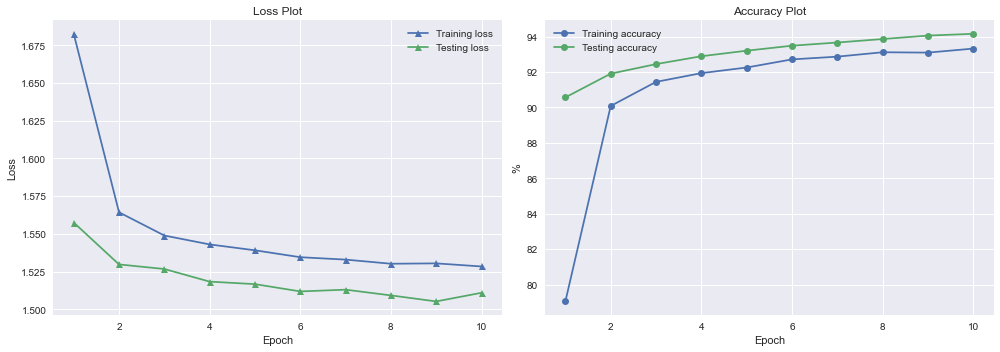

In [26]:
fig, (ax1, ax2) = plt.subplots(1,2)
ax1.plot([x for x in range(1,EPOCHS+1)], train_loss_results_denser, label='Training loss', marker='^')
ax1.plot([x for x in range(1,EPOCHS+1)], test_loss_results_denser, label='Testing loss', marker='^')
ax1.set_title("Loss Plot")
ax1.set_xlabel("Epoch")
ax1.set_ylabel("Loss")
ax2.plot([x for x in range(1,EPOCHS+1)], train_accuracy_results_denser, label='Training accuracy', marker='o')
ax2.plot([x for x in range(1,EPOCHS+1)], test_accuracy_results_denser, label='Testing accuracy', marker='o')
ax2.set_title("Accuracy Plot")
ax2.set_xlabel("Epoch")
ax2.set_ylabel("%")
ax1.legend()
ax2.legend()
fig.tight_layout()

In [27]:
model.summary()

Model: "model_denser"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
flatten_1 (Flatten)          multiple                  0         
_________________________________________________________________
dense_2 (Dense)              multiple                  35325     
_________________________________________________________________
dropout_1 (Dropout)          multiple                  0         
_________________________________________________________________
dense_3 (Dense)              multiple                  1610      
_________________________________________________________________
dense_4 (Dense)              multiple                  828       
_________________________________________________________________
dense_5 (Dense)              multiple                  240       
Total params: 38,003
Trainable params: 38,003
Non-trainable params: 0
__________________________________________________

# Adding Convolutions <a name="model3"></a>
* Convolutional Layer w/ RELU activation
* Flattening Layer
* Dense Layer 1 w/ RELU activation
* Dense Layer 2 w/ Linear activation

In [28]:
class ModelConv(Model):
    def __init__(self):
        super(ModelConv, self).__init__()
        self.conv1 = Conv2D(32, 3, activation='relu')
        self.flatten = Flatten()
        self.d1 = Dense(128, activation='relu')
        self.d2 = Dense(10)
    def call(self, x):
        x = self.conv1(x)
        x = self.flatten(x)
        x = self.d1(x)
        return self.d2(x)

model=ModelConv()

In [29]:
loss_object = tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True)
optimizer = tf.keras.optimizers.Adam()

In [30]:
train_loss = tf.keras.metrics.Mean(name='train_loss')
train_acc = tf.keras.metrics.SparseCategoricalAccuracy(name='train_accuracy')

test_loss = tf.keras.metrics.Mean(name='test_loss')
test_acc = tf.keras.metrics.SparseCategoricalAccuracy(name='test_accuracy')

In [31]:
@tf.function
def train_step(images, labels):
    with tf.GradientTape() as tape:
        predictions = model(images, training=True)
        loss = loss_object(labels, predictions)
    gradients = tape.gradient(loss, model.trainable_variables)
    optimizer.apply_gradients(zip(gradients, model.trainable_variables))

    train_loss(loss)
    train_acc(labels, predictions)

In [32]:
@tf.function
def test_step(images, labels):
    predictions = model(images, training=False)
    t_loss = loss_object(labels, predictions)

    test_loss(t_loss)
    test_acc(labels, predictions)

In [33]:
train_log_dir = 'logs/gradient_tape/convolutional/train'
test_log_dir = 'logs/gradient_tape/convolutional/test'
train_summary_writer = tf.summary.create_file_writer(train_log_dir)
test_summary_writer = tf.summary.create_file_writer(test_log_dir)

In [34]:
EPOCHS = 10

In [ ]:
train_loss_results_conv = []
train_accuracy_results_conv = []
test_loss_results_conv = []
test_accuracy_results_conv = []

for epoch in range(EPOCHS):
  # Reset the metrics at the start of the next epoch
    train_loss.reset_states()
    train_acc.reset_states()
    test_loss.reset_states()
    train_acc.reset_states()

    for images, labels in train_ds:
        train_step(images, labels)
    with train_summary_writer.as_default():
        tf.summary.scalar('loss', train_loss.result(), step=epoch)
        tf.summary.scalar('accuracy', train_acc.result(), step=epoch)

    for test_images, test_labels in test_ds:
        test_step(test_images, test_labels)
    with test_summary_writer.as_default():
        tf.summary.scalar('loss', test_loss.result(), step=epoch)
        tf.summary.scalar('accuracy', test_acc.result(), step=epoch)

    template = 'Epoch {}, Loss: {}, Accuracy: {}, Test Loss: {}, Test Accuracy: {}'
    print(template.format(epoch + 1,
                        train_loss.result(),
                        train_acc.result() * 100,
                        test_loss.result(),
                        test_acc.result() * 100))
    train_loss_results_conv.append(train_loss.result())
    train_accuracy_results_conv.append(train_acc.result() * 100)
    test_loss_results_conv.append(test_loss.result())
    test_accuracy_results_conv.append(test_acc.result() * 100)


If you intended to run this layer in float32, you can safely ignore this warning. If in doubt, this warning is likely only an issue if you are porting a TensorFlow 1.X model to TensorFlow 2.

To change all layers to have dtype float64 by default, call `tf.keras.backend.set_floatx('float64')`. To change just this layer, pass dtype='float64' to the layer constructor. If you are the author of this layer, you can disable autocasting by passing autocast=False to the base Layer constructor.

Epoch 1, Loss: 0.13508276641368866, Accuracy: 95.85166931152344, Test Loss: 0.06250783801078796, Test Accuracy: 97.97000122070312
Epoch 2, Loss: 0.042689453810453415, Accuracy: 98.70832824707031, Test Loss: 0.04973787069320679, Test Accuracy: 98.20500183105469
Epoch 3, Loss: 0.02256181836128235, Accuracy: 99.23833465576172, Test Loss: 0.0709419772028923, Test Accuracy: 98.07666778564453
Epoch 4, Loss: 0.01371733658015728, Accuracy: 99.54499816894531, Test Loss: 0.059853099286556244, Test Accuracy: 98.12

In [ ]:
fig, (ax1, ax2) = plt.subplots(1,2)
ax1.plot([x for x in range(1,EPOCHS+1)], train_loss_results_conv, label='Training loss', marker='^')
ax1.plot([x for x in range(1,EPOCHS+1)], test_loss_results_conv, label='Testing loss', marker='^')
ax1.set_title("Loss Plot")
ax1.set_xlabel("Epoch")
ax1.set_ylabel("Loss")
ax2.plot([x for x in range(1,EPOCHS+1)], train_accuracy_results_conv, label='Training accuracy', marker='o')
ax2.plot([x for x in range(1,EPOCHS+1)], test_accuracy_results_conv, label='Testing accuracy', marker='o')
ax2.set_title("Accuracy Plot")
ax2.set_xlabel("Epoch")
ax2.set_ylabel("%")
ax1.legend()
ax2.legend()
fig.tight_layout()

In [ ]:
model.summary()

# Model Comparison <a name="compare"></a>

In [ ]:
fig, (ax1, ax2) = plt.subplots(1,2)
ax1.plot([x for x in range(1,EPOCHS+1)], test_loss_results_baseline, label='Loss Model-1', marker='^')
ax1.plot([x for x in range(1,EPOCHS+1)], test_loss_results_denser, label='Loss Model-2', marker='^')
ax1.plot([x for x in range(1,EPOCHS+1)], test_loss_results_conv, label='Loss Model-3', marker='^')
ax1.set_title("Testing Loss")
ax1.set_xlabel("Epoch")
ax1.set_ylabel("Loss")
ax2.plot([x for x in range(1,EPOCHS+1)], test_accuracy_results_baseline, label='Accuracy Model-1', marker='o')
ax2.plot([x for x in range(1,EPOCHS+1)], test_accuracy_results_denser, label='Accuracy Model-2', marker='o')
ax2.plot([x for x in range(1,EPOCHS+1)], test_accuracy_results_conv, label='Accuracy Model-3', marker='o')
ax2.set_title("Testing Accuracy")
ax2.set_xlabel("Epoch")
ax2.set_ylabel("%")
ax1.legend()
ax2.legend()
fig.tight_layout()

In [ ]:
!tensorboard --logdir logs/